In [25]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from qdots_qll.models.game import get_SIC_POVM_4D
import numpy as np

import qutip as qt

from jax.scipy.linalg import expm
from jax import jit

In [10]:
from qbism import sic_povm

In [11]:
def dag(A):
    return jnp.conjugate(A.T)


def sprepost(A, B):
    return jnp.kron(A, jnp.conjugate(B))


def spre(A):
    return sprepost(A, jnp.identity(2))


def spost(A):
    return sprepost(jnp.identity(2), A)


# def vec(A):
#     return A.flatten()
def vec(A):
    return A.flatten()
    # return A.flatten()[:, jnp.newaxis]

In [12]:
d = 2

In [13]:
povm_arr = jnp.array(sic_povm(d)) * d

In [14]:
?sic_povm

Signature: sic_povm(d)
Docstring: Returns a SIC-POVM of dimension $d$.
File:      ~/miniconda3/envs/jax/lib/python3.11/site-packages/qbism/sics.py
Type:      function

In [15]:
rng = np.random.default_rng(seed=1)

In [16]:
A = rng.random([2, 2]) + 1j * rng.random([2, 2])
B = rng.random([2, 2]) + 1j * rng.random([2, 2])
C = rng.random([2, 2]) + 1j * rng.random([2, 2])

In [17]:
vec(A @ B @ dag(C))

Array([1.1492252-0.04091862j, 1.6888942+0.01579123j,
       0.9675945+0.25725535j, 1.3005437+0.55467325j], dtype=complex64)

In [18]:
jnp.kron(A, jnp.conjugate(C)) @ vec(B)

Array([1.1492252-0.04091859j, 1.6888943+0.01579124j,
       0.9675946+0.25725538j, 1.3005437+0.5546732j ], dtype=complex64)

In [19]:
# def vec(A):
#     return A.flatten()[:, np.newaxis]

In [20]:
rho = qt.rand_dm(2, seed=1).full()

In [21]:
K = (d + 1) * jnp.array([vec(pi) for pi in list(povm_arr)]).T - jnp.array(
    [vec(jnp.identity(2))] * d**2
).T

In [22]:
K_inv = (jnp.array([dag(vec(pi)) for pi in list(povm_arr)])) / d

In [26]:
@jit
def _make_C(H, V):
    return H - 1j / 2 * dag(V) @ V


@jit
def _make_Lambda(H, V):
    return (
        -1j * (spre(H) - spost(H))
        + sprepost(V, dag(V))
        - 0.5 * (spre(dag(V) @ V) + spost(dag(V) @ V))
    )


@jit
def make_L(K, K_inv, H, V):
    return K_inv @ _make_Lambda(H, V) @ K

In [58]:
# V = jnp.sqrt(0.1) * qt.sigmap().full() * 1
V = jnp.sqrt(0.1) * qt.sigmam().full() * 1

In [59]:
rho0 = qt.ket2dm(qt.basis(2, 0)).full()

In [60]:
omega = 0.5

H = omega / 2 * qt.sigmax().full()

In [61]:
L = make_L(K, K_inv, H, V)

In [62]:
my_povm = jnp.array(
    (qt.identity(2).full() + jnp.array([qt.sigmaz(), -qt.sigmaz()])) / 2
)

In [63]:
m = jnp.einsum("iljj", jnp.einsum("ijk, lkn ->iljn", my_povm, povm_arr))


E = jnp.einsum("i, m -> im", jnp.einsum("ijj", my_povm), jnp.ones(d**2))

M = (d + 1) * m - E

In [64]:
def rho_to_psic(rho, povm_arr, d):
    return jnp.einsum("ill", jnp.einsum("ijk, kl -> ijl", povm_arr, rho)) / d

In [65]:
def psic_to_rho(p_arr, povm_arr, d):
    K = (d + 1) * povm_arr - jnp.identity(2)
    return jnp.einsum("ijk,i", K, p_arr)

In [66]:
P_0 = rho_to_psic(qt.ket2dm(qt.basis(2, 0)).full(), povm_arr, d)

In [67]:
L = make_L(K, K_inv, H, V)

In [68]:
times = jnp.linspace(0, 100, 1000)

In [69]:
P_times = jax.vmap(lambda t: expm(L * t) @ P_0)(times)

/home/antonio/miniconda3/envs/jax/lib/python3.11/site-packages/jax/_src/array.py:377: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


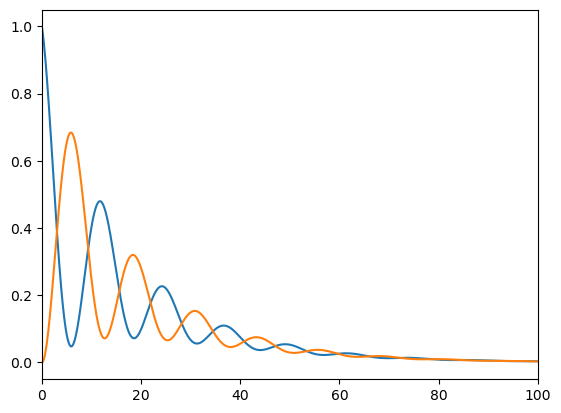

In [70]:
plt.plot(times, jax.vmap(lambda psic: M @ psic)(P_times).T[0])
plt.plot(times, jax.vmap(lambda psic: M @ psic)(P_times).T[1])
plt.xlim(0, 100)
plt.show()

In [72]:
import equinox as eqx

In [111]:
@jit
def sprepost(A, B):
    return jnp.kron(A, jnp.conjugate(B))


def make_K(d, povm_arr):
    K = (d + 1) * jnp.array([vec(pi) for pi in list(povm_arr)]).T - jnp.array(
        [vec(jnp.identity(d))] * d**2
    ).T
    return K


def make_K_inv(d, povm_arr):
    return (jnp.array([dag(vec(pi)) for pi in list(povm_arr)])) / d


dimensions_list = [2, 3, 4, 5, 6, 7]
dimensions_list_str = [str(i) for i in dimensions_list]


list_sic_povm_arr = list(
    [(lambda d: jnp.array(sic_povm(d)) * d)(d) for d in dimensions_list]
)

list_K_mat = []
list_K_inv_mat = []
for i in zip(dimensions_list, list_sic_povm_arr):
    list_K_mat.append(make_K(*i))
    list_K_inv_mat.append(make_K_inv(*i))

sic_povm_dictionary = dict(
    map(lambda i, j: (i, j), dimensions_list_str, list_sic_povm_arr)
)

K_mat_dictionary = dict(
    map(lambda i, j: (i, j), dimensions_list_str, list_K_mat)
)

K_inv_mat_dictionary = dict(
    map(lambda i, j: (i, j), dimensions_list_str, list_K_inv_mat)
)

In [116]:
class sic_povm_model(eqx.Module):
    d: int
    md: jnp.array
    sic_povm_arr: jnp.array
    K_mat: jnp.array
    K_inv_mat: jnp.array

    def __init__(self, d):
        self.d = d
        self.md = jnp.ones([d, d])
        self.sic_povm_arr = sic_povm_dictionary[str(d)]
        self.K_mat = K_mat_dictionary[str(d)]
        self.K_inv_mat = K_inv_mat_dictionary[str(d)]

    @jit
    def example_f(self):
        return jnp.identity(d)

    @jit
    def spre(self, A):
        return sprepost(A, jnp.identity(self.md.shape[0]))

    @jit
    def spost(self, A):
        return sprepost(jnp.identity(self.md.shape[0]), A)

In [267]:
class my_model(sic_povm_model):
    number_of_parameters: int
    omega: float
    gamma: float
    rho_0: jnp.array
    P_0: jnp.array
    measurement_POVM: jnp.array
    M: jnp.array

    def __init__(self, d, rho_0, measurement_POVM):
        super().__init__(d)
        self.number_of_parameters = 2
        self.omega = 0.5
        self.gamma = 0.1
        self.rho_0 = rho_0
        self.P_0 = self.rho_to_psic(rho_0)
        self.measurement_POVM = measurement_POVM
        self.M = self.M_sic_to_mypovm(self.measurement_POVM)

    @jit
    def make_H0(self):
        return jnp.array([[0, 1], [1, 0]])

    @jit
    def make_dissipator(self):
        V = jnp.array([[1, 0], [0, 0]])
        return sprepost(V, dag(V)) - 0.5 * (
            spre(dag(V) @ V) + spost(dag(V) @ V)
        )

    @jit
    def M_sic_to_mypovm(self, my_povm):
        d = self.md.shape[0]
        m = jnp.einsum(
            "iljj", jnp.einsum("ijk, lkn ->iljn", my_povm, self.sic_povm_arr)
        )
        E = jnp.einsum(
            "i, m -> im", jnp.einsum("ijj", my_povm), jnp.ones(d**2)
        )
        M = (d + 1) * m - E
        return M

    @jit
    def rho_to_psic(self, rho):
        d = self.md.shape[0]
        povm_arr = self.sic_povm_arr
        return (
            jnp.einsum("ill", jnp.einsum("ijk, kl -> ijl", povm_arr, rho)) / d
        )

    @jit
    def sic_to_povm(self, sicP):
        M = self.M
        return M @ sicP

    @jit
    def psic_to_rho(self, p_array):
        d = self.md.shape[0]
        povm_arr = self.sic_povm_arr
        K = (d + 1) * povm_arr - jnp.identity(2)
        return jnp.einsum("ijk,i", K, p_array)

    @jit
    def make_L(self, particle):
        omega = particle[0]
        gamma = particle[1]
        H = omega * self.make_H0()
        D = gamma * self.make_dissipator()
        return -1j * (spre(H) - spost(H)) + D

    @jit
    def make_LP(self, particle):
        L = self.make_L(particle)

        return self.K_inv_mat @ L @ self.K_mat

    # TODO Make the function that computes P safe.
    @jit
    def likelihood_sic_particle(self, particle, t):
        L = self.make_LP(particle)
        return jnp.real(expm(L * t) @ self.P_0)

    @jit
    def likelihood_povm_particle(self, particle, t):
        evolved_Psic = self.likelihood_sic_particle(particle, t)

        return jnp.real(self.sic_to_povm(evolved_Psic))

    # @jit
    # def fim_sic(self, particle, t):
    #     """Given a particle and time, computes the Fisher Information Matrix

    #     Args:
    #         particle (_type_): (j)np array of particle
    #         t (_type_): time

    #     Returns:
    #         _type_: _description_
    #     """
    #     jacobian = jax.jacobian(self.likelihood_sic_particle, 0)(particle, t)
    #     lkl = self.likelihood_sic_particle(particle, t)
    #     return jnp.einsum("ij, ik, i -> jk", jacobian, jacobian, 1 / lkl)

    # @jit
    # def fim_povm(self, particle, t):
    #     jacobian = jax.jacobian(self.likelihood_povm_particle, 0)(particle, t)
    #     lkl = self.likelihood_povm_particle(particle, t)
    #     return jnp.einsum("ij, ik, i -> jk", jacobian, jacobian, 1 / lkl)

    # @jit
    # def log_lkl_sic_particle(self, particle, t):
    #     L = self.make_LP(particle)
    #     return (L * t) + jnp.log(  self.P_0)

In [268]:
my_povm

Array([[[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]]], dtype=complex64)

In [269]:
model = my_model(2, rho0, my_povm)

In [265]:
model.fim_povm()

TypeError: my_model.fim_povm() missing 2 required positional arguments: 'particle' and 't'

In [266]:
model.fim_povm([model.omega, model.gamma], 3)

/home/antonio/miniconda3/envs/jax/lib/python3.11/site-packages/jax/_src/lax/lax.py:2652: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[2].
The error occurred while tracing the function fim_povm at /tmp/ipykernel_57913/106372030.py:103 for jit. This concrete value was not available in Python because it depends on the values of the arguments self.d, self.md, self.sic_povm_arr, self.K_mat, self.K_inv_mat, self.number_of_parameters, self.omega, self.gamma, self.rho_0, self.P_0, self.measurement_POVM, self.M, particle[0], particle[1], and t.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [270]:
times = jnp.linspace(0, 150, 2000)

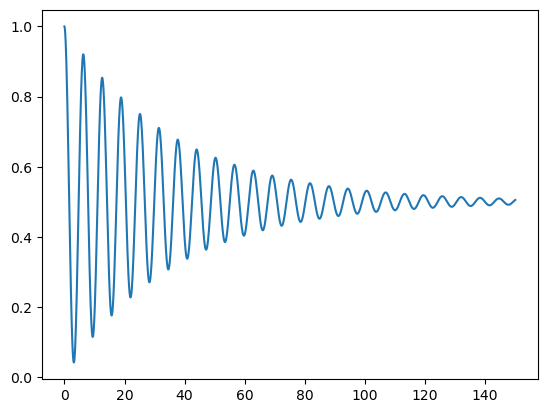

In [271]:
plt.plot(
    times,
    jnp.real(
        jax.vmap(
            lambda t: model.likelihood_povm_particle(
                [model.omega, 1.1 * model.gamma], t
            )[0]
        )(times)
    ),
)
plt.show()